# YOLO on TensorFlow

This notebook aims to create a trainable and usable version of YOLO on TensorFlow.

In [2]:
# *** IMPORT ***
import tensorflow as tf
from tf_yolo_utils import *   # fcts. to create custom layers

# Import kitti_utils from a different project
import sys
sys.path.insert(0, '/data2/lucas/Projects/Kitti2012')
from kitti_utils import *    # fcts. to manage the kitti dataset

In [3]:
print_labels(import_labels(700, 'train'))

----------------------------------------------------------------------
|type            |  x_max     |  x_min     |  y_min     |  y_max     |
----------------------------------------------------------------------
----------------------------------------------------------------------
|Car             |  600.06    |  581.85    |  176.1     |  190.53    |
----------------------------------------------------------------------
|Car             |  399.96    |  292.06    |  183.14    |  243.71    |
----------------------------------------------------------------------
|DontCare        |  576.27    |  559.56    |  166.69    |  188.61    |
----------------------------------------------------------------------
|DontCare        |  603.36    |  574.15    |  162.52    |  177.15    |
----------------------------------------------------------------------
|DontCare        |  624.18    |  609.56    |  161.48    |  175.06    |
----------------------------------------------------------------------


## The YOLO Architecture
![The YOLO Architecture](doc_img/YOLO_architecture.png)

The YOLO Detection network has 24 convolutional layers followed by 2 fully connected layers.

The predictions are encoded as an S x S x (B * 5 + C) tensor where S x S is the size of the grid that divides the input images. B is the number of boxes in one cell grid, C the number of conditional class probabilites.

N.B. __IoU (Intersection over Union)__ is an evaluation metric used to measure the accuracy of an object detector on a particular dataset.

![Intersection over Union Illustration](doc_img/iou_equation+examples.png)
_Source:[pyimagesearch.com](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)_ 

In [4]:
# --- HYPERPARAMETERS ---
TRAIN_PERC = 60   # Percentage of the data to put in the training set
DEV_PERC = 20     # Percentage of the data to put in the dev set
TEST_PERC = 20    # Percentage of the data to put in the test set

SEED = 42         # Seed used to randomize the dataset

BATCH_SIZE = 50   # Size of a batch of data
STEPS = 5000      # Number of step to train the CNN

IM_SIZE = 448     # 448=7*64  (Original shape of the image=(375, 1242, 3))
S = 7             # S x S grid the image is divided into
B = 2             # B = number of boxes per cell grid

# List of all the possible classes
LIST_CLASSES = ['Car', 'Van', 'Truck',
                'Pedestrian', 'Person_sitting', 
                'Cyclist', 'Tram', 'Misc', 
                'DontCare']

C = len(LIST_CLASSES)  # C = number of labelled classes

# --- IMPORT DATA ---
ids_for_training = get_data_list('train')
train_batches_ids, dev_batches_ids, test_batches_ids = prepare_dataset(ids_for_training, [TRAIN_PERC, DEV_PERC, TEST_PERC], BATCH_SIZE, SEED)

# --- IMPORT BATCH ---
# Function to import the images in the batches and to format the labels
# - TODO -

# --- DEFINE CNN ---
x = tf.placeholder(tf.float32, shape=[None, IM_SIZE, IM_SIZE, 3])
y = tf.placeholder(tf.float32, shape=[None, S * S * (B * 5 + C)])

# --- CONV. LAYER 1 ---
# 7x7x64-s-2
# Maxpool: 2x2-s-2

conv1 = conv_layer(x, shape=[7, 7, 3, 64], strides=[1,2,2,1])
conv1_pool = max_pool_2x2(conv1)

# --- CONV. LAYER 2 ---
# 3x3x192
# Maxpool: 2x2-s-2

conv2 = conv_layer(conv1_pool, shape=[3, 3, 64, 192], strides=[1,2,2,1])
conv2_pool = max_pool_2x2(conv2)

# --- CONV. LAYERS 3 ---
# 1x1x128
# 3x3x256
# 1x1x256
# 3x3x512
# Maxpool: 2x2-s-2

conv3_1 = conv_layer(conv2_pool, shape=[1, 1, 192, 128])
conv3_2 = conv_layer(conv3_1, shape=[3, 3, 128, 256])
conv3_3 = conv_layer(conv3_2, shape=[1, 1, 256, 256])
conv3_4 = conv_layer(conv3_3, shape=[3, 3, 256, 512])
conv3_pool = max_pool_2x2(conv3_4)

# --- CONV. LAYERS 4 ---
# 1x1x256  ____ x4
# 3x3x512  _|
# 1x1x512
# 3x3x1024
# Maxpool: 2x2-s-2

conv4_1 = conv_layer(conv3_pool, shape=[1, 1, 512, 256])
conv4_2 = conv_layer(conv4_1, shape=[3, 3, 256, 512])

conv4_3 = conv_layer(conv4_2, shape=[1, 1, 512, 256])
conv4_4 = conv_layer(conv4_3, shape=[3, 3, 256, 512])

conv4_5 = conv_layer(conv4_4, shape=[1, 1, 512, 256])
conv4_6 = conv_layer(conv4_5, shape=[3, 3, 256, 512])

conv4_7 = conv_layer(conv4_6, shape=[1, 1, 512, 256])
conv4_8 = conv_layer(conv4_7, shape=[3, 3, 256, 512])

conv4_9 = conv_layer(conv4_8, shape=[1, 1, 512, 512])
conv4_10 = conv_layer(conv4_9, shape=[3, 3, 512, 1024])

conv4_pool = max_pool_2x2(conv4_10)

# --- CONV. LAYERS 5 ---
# 1x1x512   ____ x2
# 3x3x1024  _|
# 3x3x1024
# 3x3x1024-s-2

conv5_1 = conv_layer(conv4_pool, shape=[1, 1, 1024, 512])
conv5_2 = conv_layer(conv5_1, shape=[3, 3, 512, 1024])

conv5_3 = conv_layer(conv5_2, shape=[1, 1, 1024, 512])
conv5_4 = conv_layer(conv5_3, shape=[3, 3, 512, 1024])

conv5_5 = conv_layer(conv5_4, shape=[3, 3, 1024, 1024])

conv5_6 = conv_layer(conv5_5, shape=[3, 3, 1024, 1024], strides=[1, 2, 2, 1])

# --- CONV. LAYERS 6 ---
# 3x3x1024
# 3x3x1024

conv6_1 = conv_layer(conv5_6, shape=[3, 3, 1024, 1024])
conv6_2 = conv_layer(conv6_1, shape=[3, 3, 1024, 1024])

# --- FULL LAYER 1 ---
# 4096

conv6_2_flatten = tf.reshape(conv6_2, [-1, 16 * 1024]) # Got it to 16*1024 to have only one l ouput per image

full_1_ = full_layer(conv6_2_flatten, 4096)
full_1 = tf.maximum(full_1_, 0.1 * full_1_)  # Leaky ReLU

full_1_drop = tf.nn.dropout(full_1, keep_prob=0.5)

# --- FULL LAYER 2 ---

full_2 = full_layer(full_1_drop, S * S * (B * 5 + C))


Input shape: (2, 448, 448, 3)
Output shape: (2, 931)


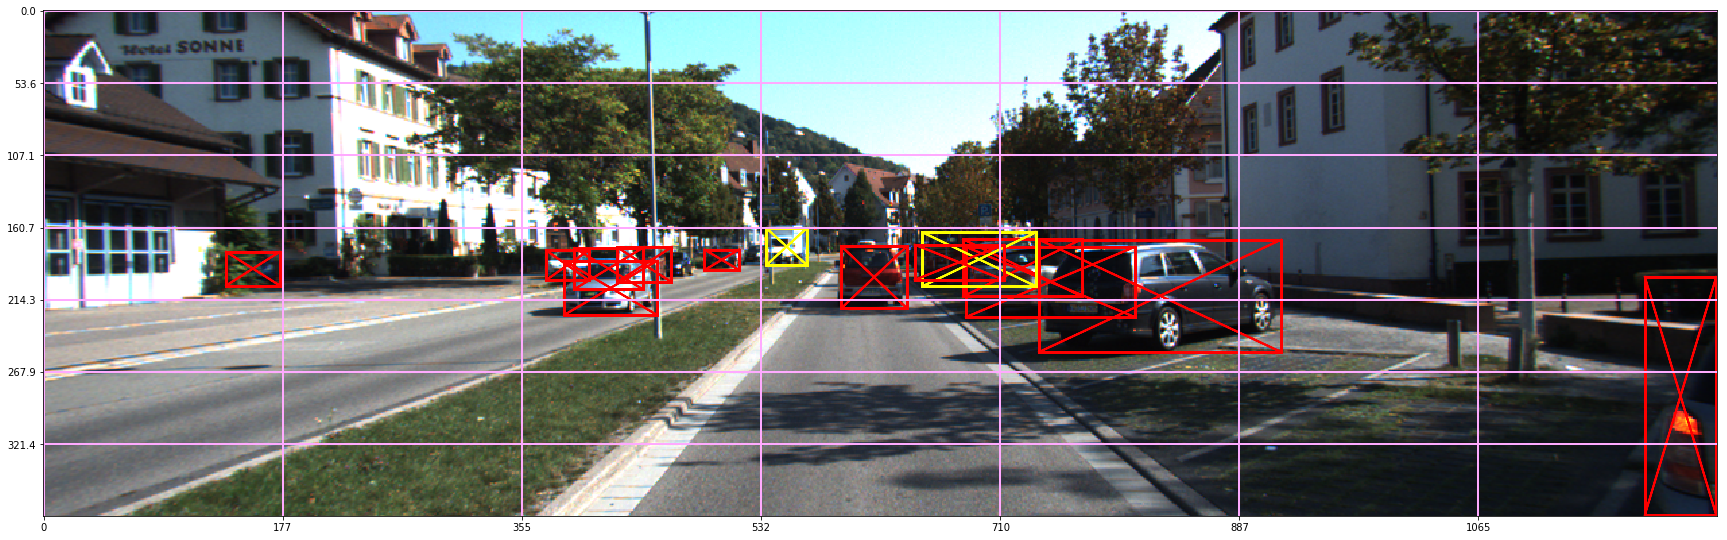

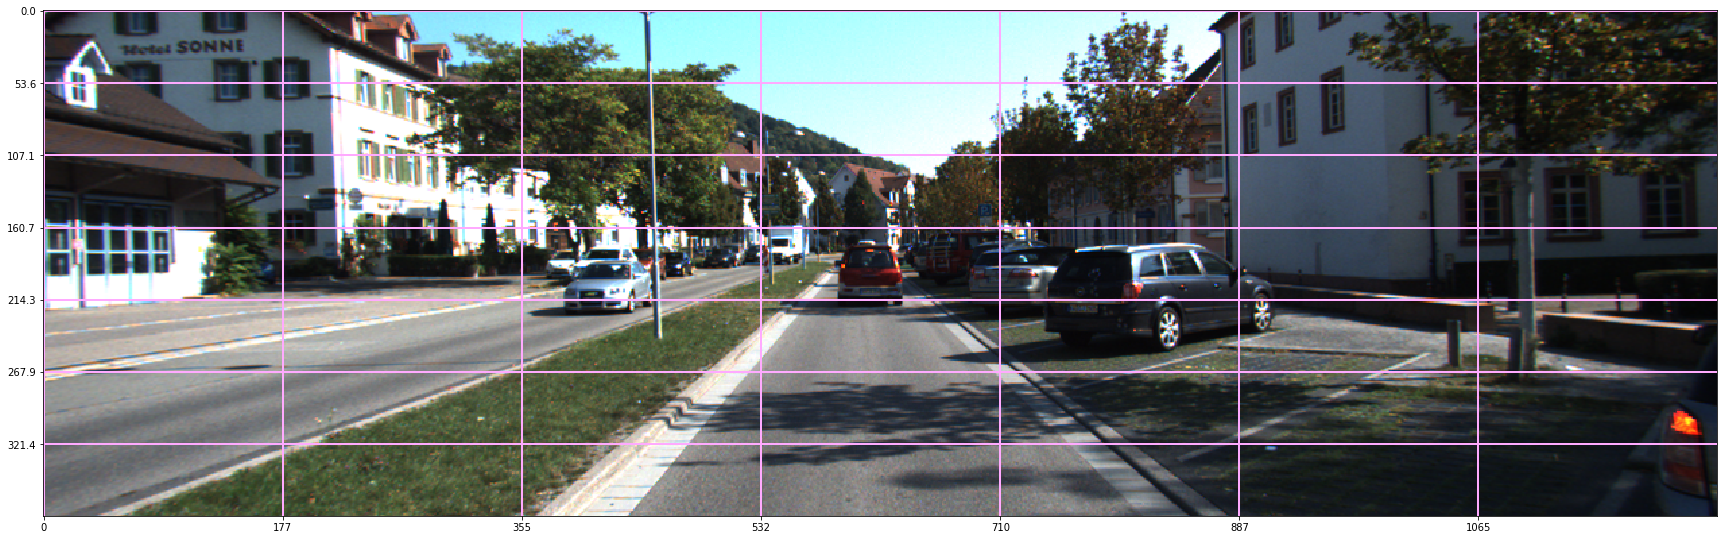

In [5]:
# try to get an image run through the CNN
# import image
im_id_1 = 111
imd_id_2 = 222

im_org_1 = import_im(im_id_1, 'train')
im_1_ = misc.imresize(im_org_1, (IM_SIZE, IM_SIZE, 3))
im_1 = im_1_.reshape([-1, IM_SIZE, IM_SIZE, 3])

im_org_2 = import_im(imd_id_2, 'train')
im_2_ = misc.imresize(im_org_2, (IM_SIZE, IM_SIZE, 3))
im_2 = im_2_.reshape([-1, IM_SIZE, IM_SIZE, 3])

im_shape = im_org_1.shape

ims = np.concatenate((im_1, im_2),axis=0)

print('Input shape: ' + str(ims.shape))

# initialize variables
sess = tf.Session()

sess.run(tf.global_variables_initializer())

result = sess.run(full_2, feed_dict = {x: ims})

print('Output shape: ' + str(result.shape))

# Show difference between ground truth and output labels
display_im(im_org_1, import_labels(im_id_1, 'train'), num_cell_grid = S, display_info = False)

labels_out = convert_array_to_labels(result[0][:], S, B, im_shape)
display_im(im_org_1, labels_out, num_cell_grid = S, display_info = False)

# print(labels_out)

## Loss Function
![The YOLO Loss Function](doc_img/YOLO_loss_function.png)

In [8]:
# May have a look tf.count_nonzero to create the 1 operator: https://www.tensorflow.org/api_docs/python/tf/count_nonzero
# E.g. https://stackoverflow.com/a/43960630

# Interesting implementation of YOLO loss: https://github.com/johnwlambert/YoloTensorFlow229/blob/master/YoloTensorFlowFunctions.py
LAMBDA_COORD = 5
LAMBDA_NOOBJ = 0.5



result

array([[ -6.03261397e+12,  -3.68021183e+12,   6.99341944e+12, ...,
          1.39058899e+12,  -2.45921533e+12,  -8.17714692e+12],
       [  9.85795265e+11,  -5.24395164e+12,   5.76864230e+12, ...,
          6.16578469e+12,  -1.06074410e+13,  -7.73581439e+12]], dtype=float32)